In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_without_father2500'
batch='WILD_without_father2500'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', 
                                   allow_pickle=True).item()

In [4]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [5]:
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

# Format data for hierarchy plotting

In [6]:
df_levels = upls.create_df_levels(volumes)

# PLS ncells

In [7]:
%%bash
python area_pls.py -i results_pls/WILD_without_father2500_n_cells.csv -o './results_pls/WILD_without_father2500_ncells'

In [8]:
%%bash
python area_pls.py -i results_pls/WILD_without_father2500_energy.csv -o './results_pls/WILD_without_father2500_energy'

In [9]:
%%bash
python area_pls.py -i results_pls/WILD_without_father2500_density.csv -o './results_pls/WILD_without_father2500_density'

In [10]:
%%bash
python area_pls.py -i results_pls/WILD_without_father2500_relative_density.csv -o './results_pls/WILD_without_father2500_relative_density'

# Plot results

In [11]:
contrasts = pd.read_csv('./results_pls/WILD_without_father_contrasts.csv')
saliences = pd.read_csv('./results_pls/WILD_without_father_saliences.csv')
contrasts = contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First salience'}, ylabel='z-score(salience)'>,
        <AxesSubplot:title={'center':'Second salience'}, ylabel='z-score(salience)'>,
        <AxesSubplot:title={'center':'Third salience'}, xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

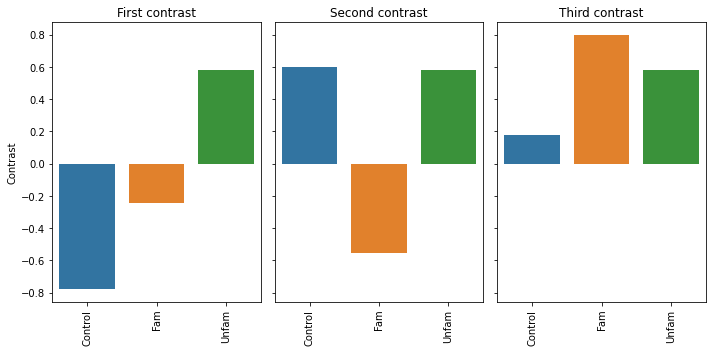

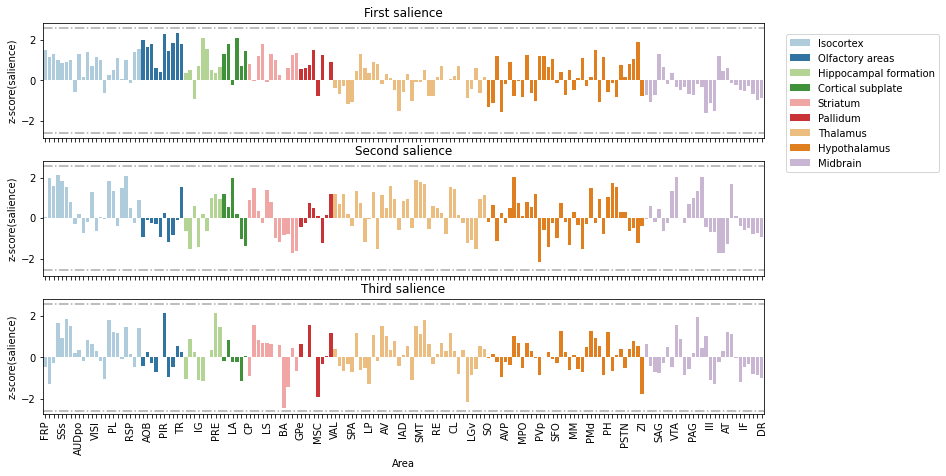

In [12]:
upls.plot_panel_contrasts(batch=batch, variable='ncells')
upls.plot_panel_saliences(batch=batch, variable='ncells', df_levels=df_levels)

# PLS energy

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First salience'}, ylabel='z-score(salience)'>,
        <AxesSubplot:title={'center':'Second salience'}, ylabel='z-score(salience)'>,
        <AxesSubplot:title={'center':'Third salience'}, xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

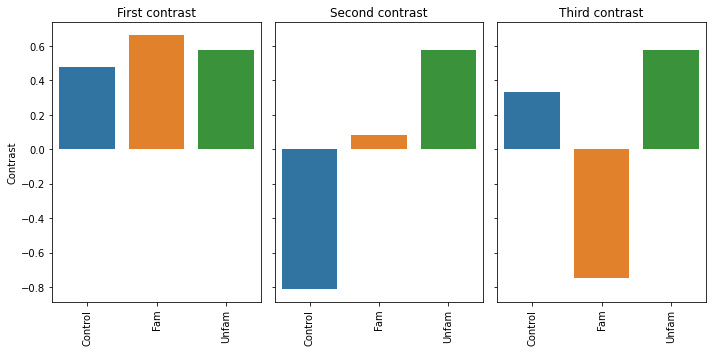

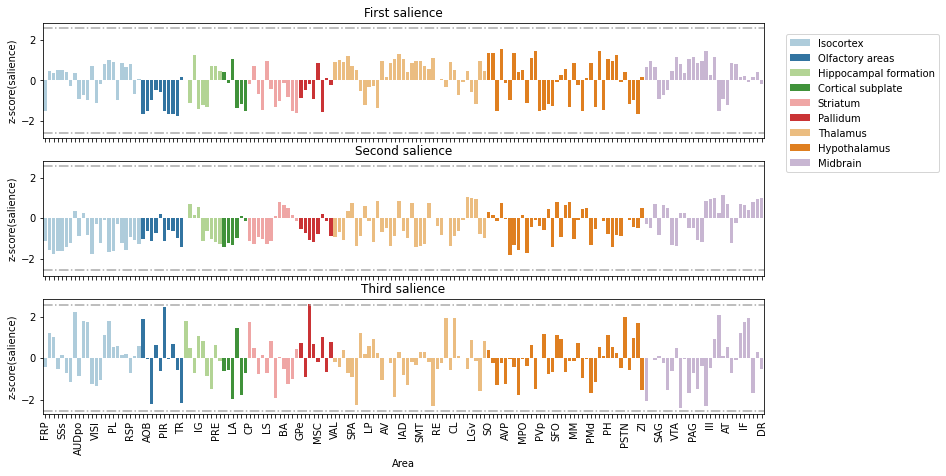

In [13]:
upls.plot_panel_contrasts(batch=batch, variable='energy')
upls.plot_panel_saliences(batch=batch, variable='energy', df_levels=df_levels)

# PLS density

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First salience'}, ylabel='z-score(salience)'>,
        <AxesSubplot:title={'center':'Second salience'}, ylabel='z-score(salience)'>,
        <AxesSubplot:title={'center':'Third salience'}, xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

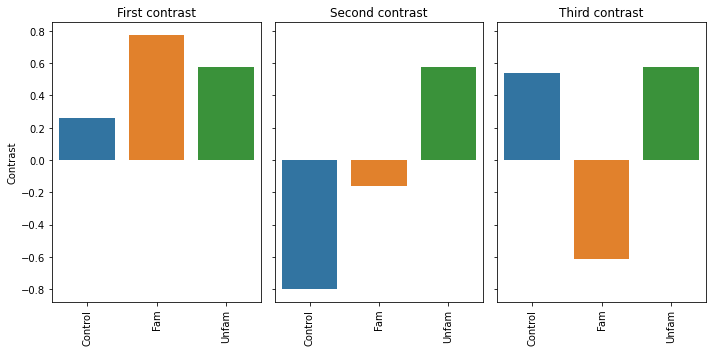

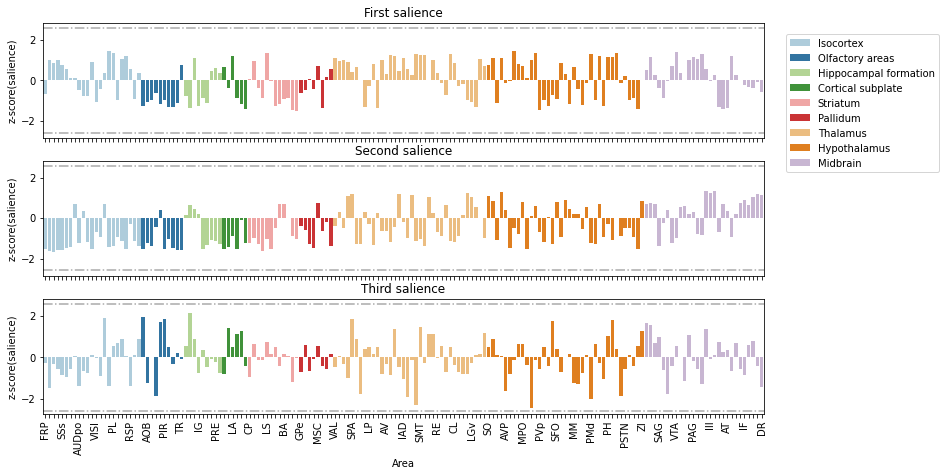

In [14]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

# PLS relative density

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First salience'}, ylabel='z-score(salience)'>,
        <AxesSubplot:title={'center':'Second salience'}, ylabel='z-score(salience)'>,
        <AxesSubplot:title={'center':'Third salience'}, xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

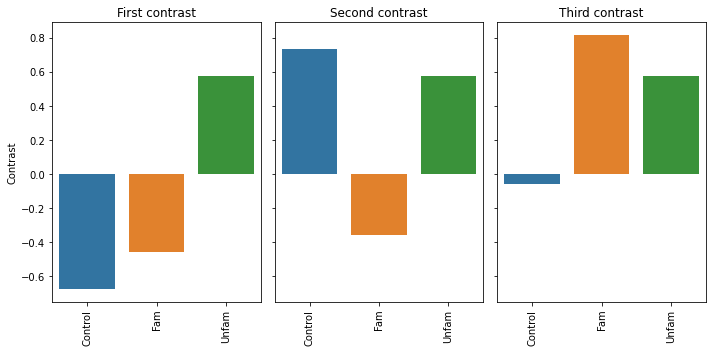

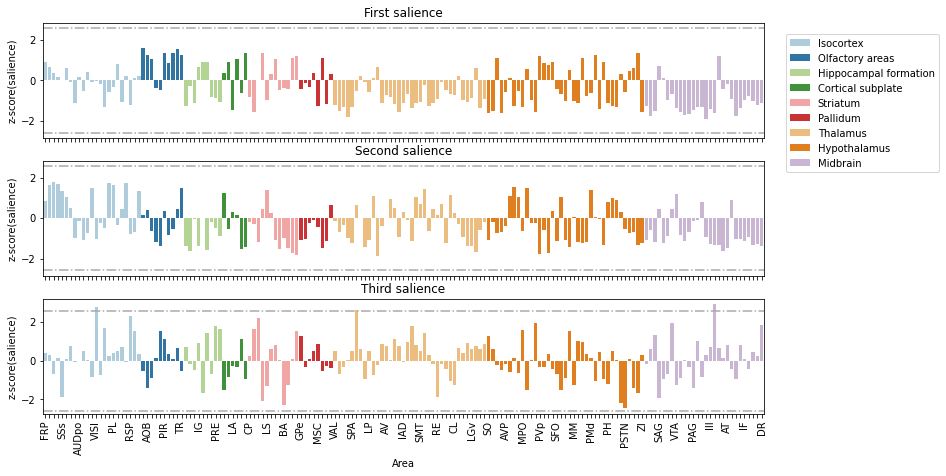

In [15]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

# Identify areas with significant salience contribution

In [16]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=saliences, 
                                       threshold=1.96, 
                                       volumes=volumes)
np.save('results_pls/pls_sig_areas_WILD_without_father.npy', pls_sig_areas)

In [17]:
pls_sig_areas = np.load('results_pls/pls_sig_areas_WILD_without_father.npy', allow_pickle=True)
pls_sig_areas

array(['Agranular insular area', 'Anterior cingulate area',
       'Dorsomedial nucleus of the hypothalamus', 'Entorhinal area',
       'Interpeduncular nucleus', 'Lateral amygdalar nucleus',
       'Main olfactory bulb',
       'Periventricular hypothalamic nucleus posterior part',
       'Piriform area', 'Piriform-amygdalar area', 'Primary motor area',
       'Primary somatosensory area', 'Supplemental somatosensory area',
       'Ventral posterior complex of the thalamus',
       'Ventral tegmental nucleus'], dtype='<U51')

In [18]:
overlap = {'ncells':[], 'energy':[], 'density':[], 'relative_density':[]}
for variable in overlap.keys():
    overlap[variable] = set(upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=1.96, 
                                           volumes=volumes))
[len(overlap[key]) for key in overlap.keys()]

[16, 13, 4, 10]

In [19]:
overlap['relative_density']

{'Bed nucleus of the accessory olfactory tract',
 'Edinger-Westphal nucleus',
 'Fundus of striatum',
 'Lateral visual area',
 'Olfactory tubercle',
 'Parasubthalamic nucleus',
 'Peripeduncular nucleus',
 'Preparasubthalamic nucleus',
 'Retrosplenial area',
 'Substantia nigra reticular part'}

In [20]:
# union between areas significant in all analyses
all_areas = overlap['ncells'].union(overlap['energy']).union(overlap['density']).union(overlap['relative_density'])
# intersection between areas significant in all analyses
intersection = overlap['ncells'].intersection(overlap['energy']).intersection(
    overlap['density']).intersection(overlap['relative_density'])
# filtering
intersection, len(intersection)

(set(), 0)